In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from scipy.optimize import differential_evolution
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data.csv")

# Select the required columns (18 elements + target)
columns_to_select = [
    'C', 'Mn', 'S', 'P', 'Si', 'Ni', 'Cr', 'Cu', 
    'Ti', 'Co', 'N', 'Pb', 'Sn', 'Al', 'B', 'V', 
    'Ca', 'Nb', 'CAPL MAIN DEFECT'
]
df = df[columns_to_select]

# Split features and target
X = df.iloc[:, :-1]  # First 18 columns (features)
y = df.iloc[:, -1]   # Last column (target)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
import lightgbm as lgb

# Convert dataset
lgb_data = lgb.Dataset(X_scaled, label=y_encoded)

# Train LightGBM model
params = {
    'objective': 'multiclass',
    'num_class': len(set(y_encoded)),
    'metric': 'multi_logloss',
    'verbosity': -1
}

lgb_model = lgb.train(params, lgb_data)


print("✅ LightGBM model trained on 100% data")

✅ LightGBM model trained on 100% data


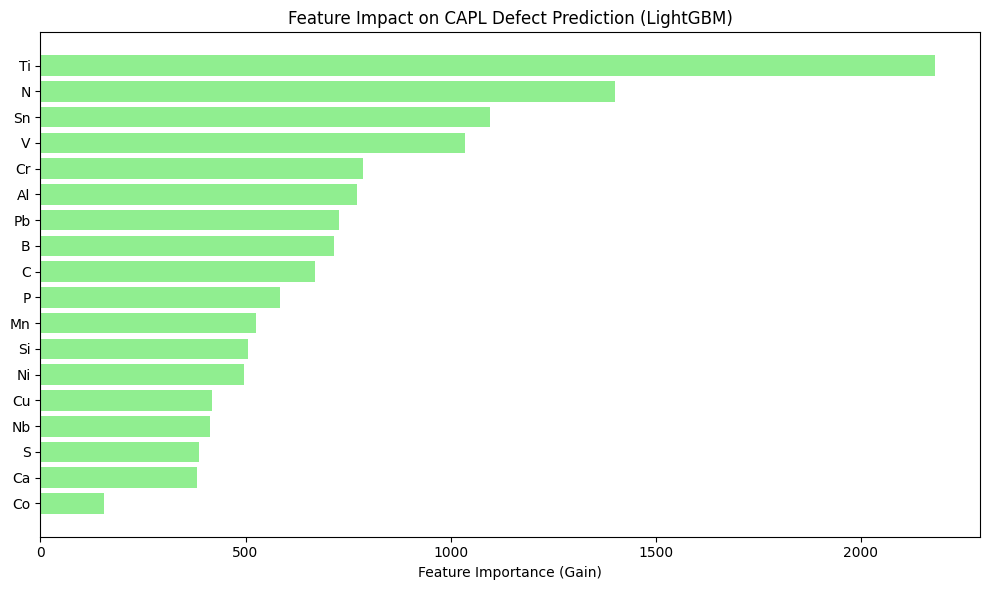

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from Booster
importances = lgb_model.feature_importance(importance_type='gain')  # or 'split'

# Use same feature names as your input data
feature_names = X.columns

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='lightgreen')
plt.xlabel("Feature Importance (Gain)")
plt.title("Feature Impact on CAPL Defect Prediction (LightGBM)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [5]:
custom_input_data = np.array([[69, 3200, 15, 310, 4000, 1600, 173500, 500,
                               3200, 400, 100, 45, 50, 365, 5, 440, 10, 20]])

# Scale the input
custom_input_scaled = scaler.transform(custom_input_data)

# Get class probabilities using predict
predicted_probabilities = lgb_model.predict(custom_input_scaled)  # shape: (1, num_classes)

# Get the predicted class index (with max probability)
predicted_label_encoded = np.argmax(predicted_probabilities, axis=1)

# Decode label
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

# Print
print(f"\nLightGBM\n=> Predicted Defect: {predicted_label[0]}\n")

print("\n## Class Probabilities (Most to Least Likely):\n")
class_probs = list(zip(label_encoder.classes_, predicted_probabilities[0]))
for class_label, prob in sorted(class_probs, key=lambda x: x[1], reverse=True):
    print(f"{class_label}: {prob:.4f}")


LightGBM
=> Predicted Defect: Inclusion Free


## Class Probabilities (Most to Least Likely):

Inclusion Free: 0.6678
Spinel Inclusion: 0.3312
SLIVER C-EDGE: 0.0004
SLIVER C-BODY: 0.0003
Casting Powder Inclusion: 0.0002
HOLE: 0.0001
ROLL PICK-UP MARK- EDGE: 0.0000
ROLL PICK-UP MARK- BODY: 0.0000
SLAB EDGE: 0.0000
SLIVER B-BODY: 0.0000
TI STREAKS: 0.0000


In [6]:
feature_bounds = [
    (0, 100), (2000, 3500), (0, 30), (200, 500), (2500, 5200),
    (0, 3000), (112000, 174000), (0, 2000), (2000, 3500), (0, 500),
    (0, 125), (0, 45), (0, 50), (100, 500), (0, 50), (0, 500),
    (0, 200), (0, 200),
]

scaled_bounds = []
original_input = custom_input_data[0]
for i, (low, high) in enumerate(feature_bounds):
    x_low = original_input.copy()
    x_high = original_input.copy()
    x_low[i] = low
    x_high[i] = high
    scaled_bounds.append((
        scaler.transform([x_low])[0][i],
        scaler.transform([x_high])[0][i]
    ))

target_class_index = list(label_encoder.classes_).index("Inclusion Free")

def objective_function_scaled(x_scaled):
    prob = lgb_model.predict(np.array([x_scaled]))[0][target_class_index]
    return -prob

result = differential_evolution(
    objective_function_scaled,
    bounds=scaled_bounds,
    strategy='best1bin',
    maxiter=1000,
    popsize=15,
    tol=1e-6,
    polish=True,
    seed=42
)

optimized_scaled_input = result.x
optimized_input = scaler.inverse_transform([optimized_scaled_input])[0]
optimized_probability = -result.fun
delta = optimized_input - custom_input_data[0]

print("\n## Suggested Adjustments to Maximize 'Inclusion Free' Probability:\n")
for name, original, change in zip(feature_names, custom_input_data[0], delta):
    print(f"{name}: {original:.2f} -> {original + change:.2f}  (Δ {change:+.2f})")

print(f"\nPredicted Inclusion Free Probability after optimization: {optimized_probability:.4f}")


## Suggested Adjustments to Maximize 'Inclusion Free' Probability:

C: 69.00 -> 82.41  (Δ +13.41)
Mn: 3200.00 -> 3361.78  (Δ +161.78)
S: 15.00 -> 14.01  (Δ -0.99)
P: 310.00 -> 311.08  (Δ +1.08)
Si: 4000.00 -> 4110.53  (Δ +110.53)
Ni: 1600.00 -> 1633.90  (Δ +33.90)
Cr: 173500.00 -> 171689.03  (Δ -1810.97)
Cu: 500.00 -> 544.05  (Δ +44.05)
Ti: 3200.00 -> 2905.79  (Δ -294.21)
Co: 400.00 -> 332.38  (Δ -67.62)
N: 100.00 -> 107.82  (Δ +7.82)
Pb: 45.00 -> 40.39  (Δ -4.61)
Sn: 50.00 -> 49.79  (Δ -0.21)
Al: 365.00 -> 227.96  (Δ -137.04)
B: 5.00 -> 4.84  (Δ -0.16)
V: 440.00 -> 499.09  (Δ +59.09)
Ca: 10.00 -> 11.75  (Δ +1.75)
Nb: 20.00 -> 28.64  (Δ +8.64)

Predicted Inclusion Free Probability after optimization: 0.9999
